In [1]:
from fastai.vision.all import *

[Averaging Weights Leads to Wider Optima and Better Generalization](https://arxiv.org/abs/1803.05407)

## Data
[Imagewoof](https://github.com/fastai/imagenette) dataset is used.

In [2]:
path = Path('/home/kushaj/Desktop/Data/imagewoof2/')
Path.BASE_PATH = path
path.ls()

(#2) [Path('train'),Path('val')]

In [3]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = GrandparentSplitter(valid_name='val'),
                item_tfms=Resize(460),
                batch_tfms=[*aug_transforms(size=224, min_scale=.75)]).dataloaders(path, bs=64, val_bs=64, n_workers=12)

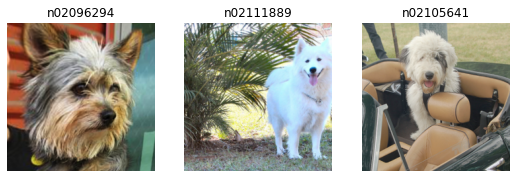

In [4]:
dls.show_batch(max_n=3)

I will experiment with *AdamW* and *Ranger(RAdam + LookAhead + Gradient Centralization)*. *XResNet-50 (ResNet-D)* is used as model architecture.

## Stochastic Weight Averaging (SWA)
SWA can be summarized as taking a weighted average of model's weight after every epoch. To get the best results it is best to not start this averaging from `epoch=0` as initially we have random weights.

So first we train ResNet model for some epochs and then start SWA. For training the model I used the following details:
* lr=1e-2
* wd=1e-2
* AdamW
* Cyclic learning [learn more](https://kushajveersingh.github.io/blog/discussion/2019/06/26/post-0010.html)

Algorithm from paper is shown below.

![](images/01.png)

In short, the algorithm can be summarized as follows
1. Maintain a copy of original weights of model as $w_{SWA}$. No training is done on these weights.
2. Train the original weights for one epoch $w$.
3. After every epoch use the following equation to update $w_{SWA}$:

$$w_{SWA} = \frac{{w_{SWA}*n_{models}+w}}{n_{models}+1}$$

* $n_{models}$ - Epoch number for which you are computing SWA. (0, 1, 2, ...)

In code, this would look something like this.

```python
start_epoch = 10 # after how many epochs, we should start swa
n_models = 0
w_swa = model.parameters() # maintain a copy of original weights

for epoch in range(epochs):
    if epoch >= start_epoch:
        w = model.parameters()
        for model_param, swa_param in zip(w, w_swa):
            swa_param.data = (swa_param.data*epoch_swa + model_param) / (n_models + 1)
        n_models += 1
    
    # Normal training code follows
```

4. Fix running averages of *Batch Normalization* layer. As the SWA model never gets trained the running mean and variance of normalization layer do not correspond to the training data. This can be solved by doing a forward pass using $w_{SWA}$ for one epoch after the training is finished.
    In implementation, first set the *running_mean* and *running_var* to zero and then train for one epoch.

### Callback
To use SWA in fastai, we can implement a callback that will do all the above things for us.

Some implementation details:
1. To avoid GPU->CPU transfer, SWA is done on the GPU. This means the GPU needs to store another copy of the model. In most cases this is not a big deal, as models do not take much space. But if you want to do the computation on the CPU, you can move the weights to the CPU in the below implementation.

In [5]:
from copy import deepcopy

class SWA(Callback):
    def __init__(self, start_epoch=0): self.start_epoch,self.n_models = start_epoch,0
    def before_fit(self): 
        self.swa_state = deepcopy(self.learn.model.state_dict())
        for k in self.swa_state.keys(): self.swa_state[k] = self.swa_state[k].to('cuda')
    
    def after_epoch(self):
        if self.start_epoch <= self.epoch:
            for k,w in self.learn.model.state_dict().items():
                self.swa_state[k] = torch.true_divide(self.swa_state[k]*self.n_models+w, self.n_models+1)
            self.n_models += 1
    
swa = SWA(5)

To show accuracy of the model using SWA model, we need to define another callback that would update the callback.

In [6]:
learn = cnn_learner(dls, xresnet34, pretrained=False, cbs=[swa], metrics=[accuracy], path='.', wd=1e-2).to_fp16()

In [7]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.683183,2.271438,0.240519,00:22
1,2.314981,2.563498,0.226521,00:21
2,2.057813,2.416861,0.213286,00:21
3,1.709749,2.190006,0.312293,00:21
4,1.530028,1.603254,0.443624,00:22
5,1.343507,1.363776,0.520743,00:22
6,1.188103,1.160516,0.604225,00:21
7,1.023926,0.923142,0.687961,00:22
8,0.887272,0.820640,0.717485,00:22
9,0.841475,0.800335,0.721303,00:22


### Check accuracy with swa (not updating norm values)

In [8]:
learn.model.load_state_dict(learn.swa.swa_state)

<All keys matched successfully>

In [9]:
learn.validate()

(#2) [0.8901645541191101,0.6978874802589417]

Both `valid_loss` and `accuracy` are worse. Now let's see if we can get better results by updating the running means and variances.

### Update running values

In [10]:
for m in learn.model.modules():
    if isinstance(m, nn.modules.batchnorm._BatchNorm):
        m.running_mean = torch.zeros_like(m.running_mean)
        m.running_var = torch.ones_like(m.running_var)

In [31]:
# Do a forward pass
learn.model.train()

for (*x,y) in iter(dls[1]):
    xs = x[0]
    bs = xs.shape[0]
    momentum = bs/(inputs_seen+bs)
    for module in bn_modules: module.momentum = momentum
    learn.model(xs)
    inputs_seen += bs
for module, momentum in zip(bn_modules, momenta):
    module.momentum = momentum

In [32]:
learn.validate()

(#2) [1.5188075304031372,0.5635021924972534]